In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
from PIL import Image

In [2]:
def segment_and_crop_image(image, model, show_images=False):
    # Show the original image
    if show_images:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')
        plt.show()
    # Run inference on a single image
    result = model(image)[0]  # Get the first (and only) result
    cropped_images = []

    # Process result
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for instance segmentation masks
    class_names = result.names  # Class names for the detected objects
    
    if masks is not None:
        for idx, (box, mask) in enumerate(zip(boxes, masks)):
            
            # Get the predicted class name
            class_id = int(box.cls[0])
            class_name = class_names[class_id]

            # Skip if the class is not a person
            if class_name != 'person':
                print(f"Skipping box {idx+1} as it is not a person.")
                continue
            
            # Get coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Convert mask to NumPy array and get the mask coordinates
            mask_np = mask.data.squeeze(0).cpu().numpy()
            mask_coords = mask.xy[0]
            
            # Create a blank mask with the same dimensions as the original image
            blank_mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Fill the blank mask with the mask coordinates
            cv2.fillPoly(blank_mask, [mask_coords.astype(np.int32)], 1)
            
            # Apply the mask to the original image
            masked_image = cv2.bitwise_and(image, image, mask=blank_mask)
            
            # Crop the masked image using the bounding box coordinates
            cropped_masked_img = masked_image[y1:y2, x1:x2]
            cropped_images.append(cropped_masked_img)
            
            if show_images:
                # Display the masked cropped image with the class name in the title
                plt.imshow(cv2.cvtColor(cropped_masked_img, cv2.COLOR_BGR2RGB))
                plt.title(f'Masked Cropped Box {idx+1} - Class: {class_name}')
                plt.axis('off')
                plt.show()
    else:
        print("No masks detected.")
    
    return cropped_images

def get_segmentation_mask(image, processor, model):
    """
    Function to segment clothes in an image.

    Parameters:
    - image: PIL.Image object, the image to segment.
    - processor: SegformerImageProcessor object, the processor used to preprocess the image.
    - model: AutoModelForSemanticSegmentation object, the model used to segment the image.

    Returns:
    - pred_seg: torch.Tensor, the segmented image.
    """
    inputs = processor(images=image, return_tensors="pt")

    outputs = model(**inputs)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]

    # Create a mask for the labels 4, 5, 6, and 7
    mask = (pred_seg == 4) | (pred_seg == 5) | (pred_seg == 6) | (pred_seg == 7) | (pred_seg == 8) | (pred_seg == 16) | (pred_seg == 17)

    # Set all other labels to 0
    pred_seg[~mask] = 0

    # Set the labels 4, 5, 6, and 7 to 255
    pred_seg[mask] = 255

    return pred_seg
    
    # plt.imshow(pred_seg)

# Human Cropping

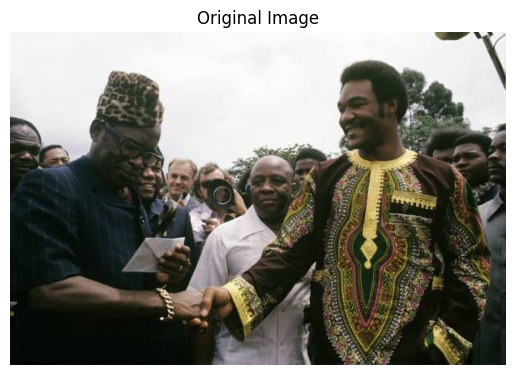


0: 448x640 12 persons, 785.9ms
Speed: 3.3ms preprocess, 785.9ms inference, 11.9ms postprocess per image at shape (1, 3, 448, 640)


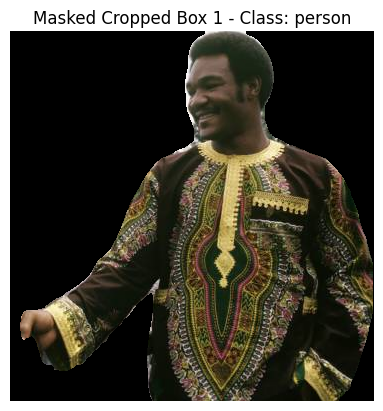

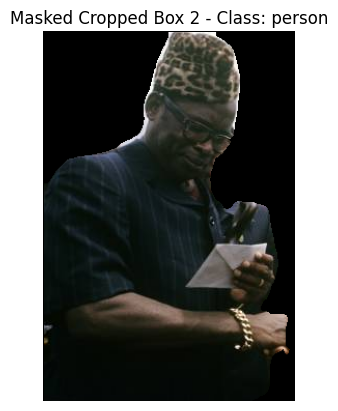

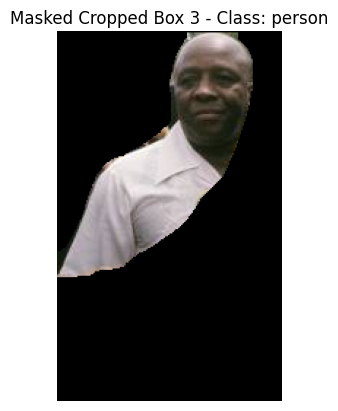

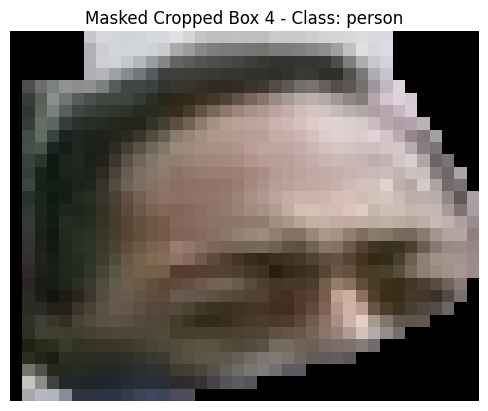

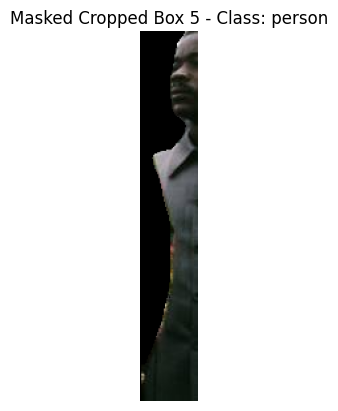

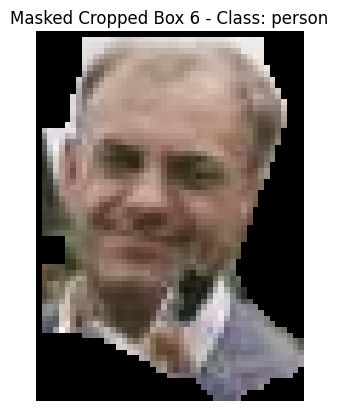

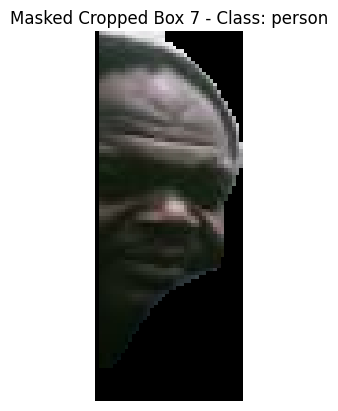

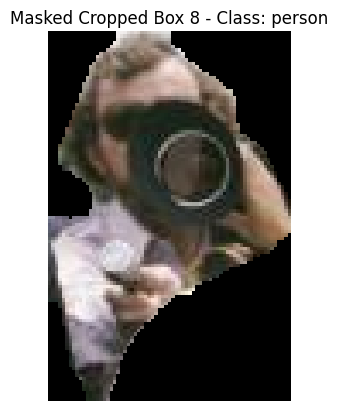

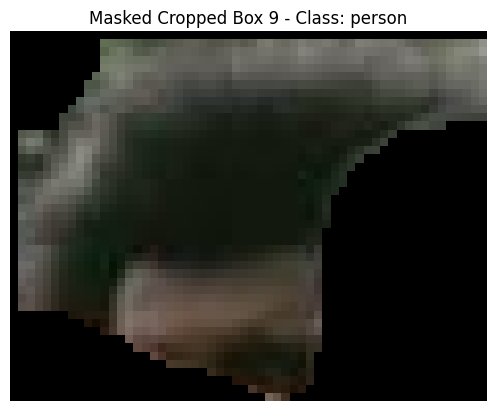

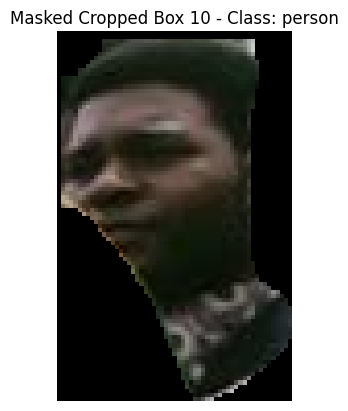

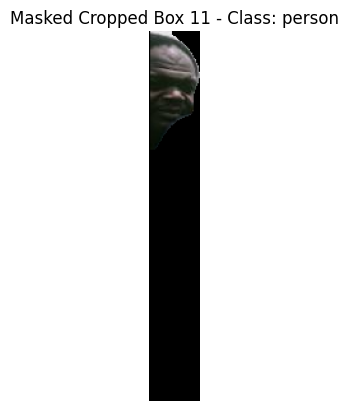

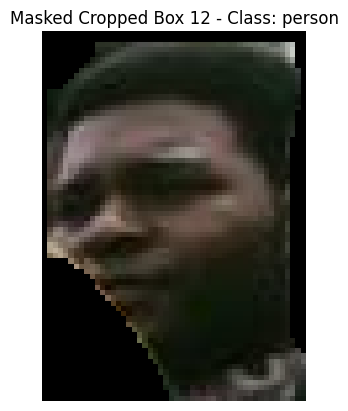

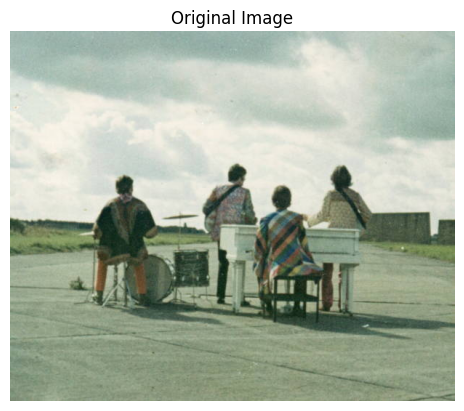


0: 544x640 5 persons, 2 handbags, 1 chair, 930.5ms
Speed: 2.6ms preprocess, 930.5ms inference, 9.7ms postprocess per image at shape (1, 3, 544, 640)


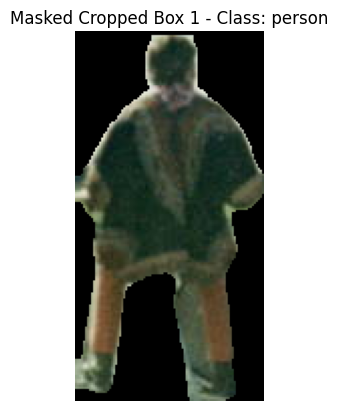

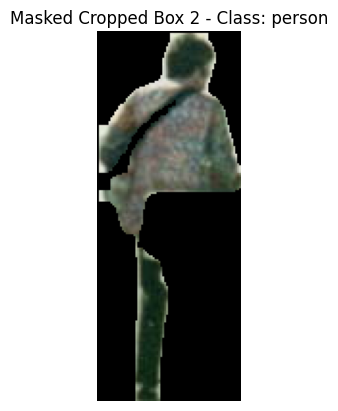

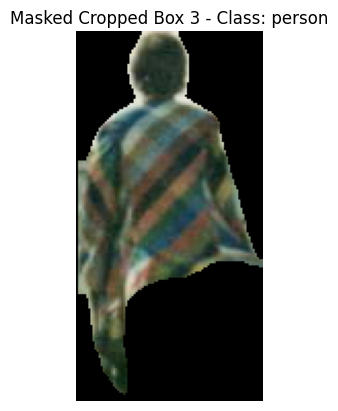

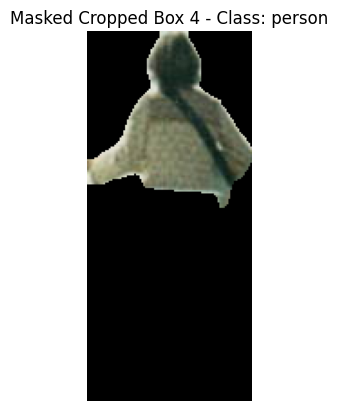

Skipping box 5 as it is not a person.
Skipping box 6 as it is not a person.
Skipping box 7 as it is not a person.


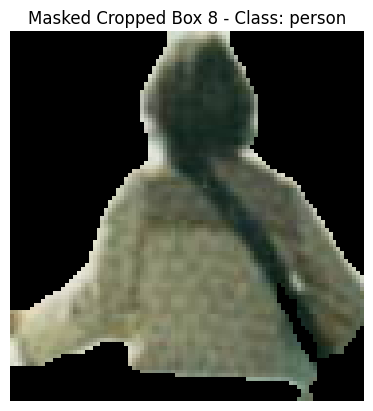

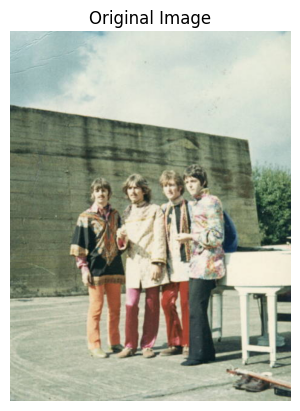


0: 640x512 4 persons, 1 backpack, 1 tie, 1 skateboard, 1105.5ms
Speed: 2.6ms preprocess, 1105.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 512)


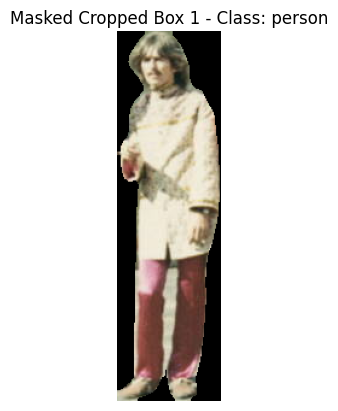

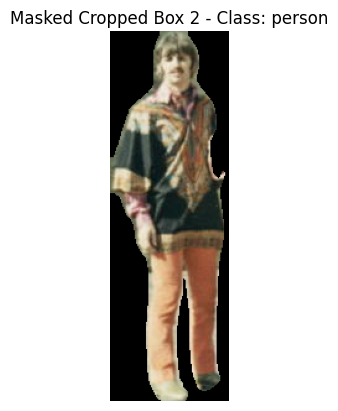

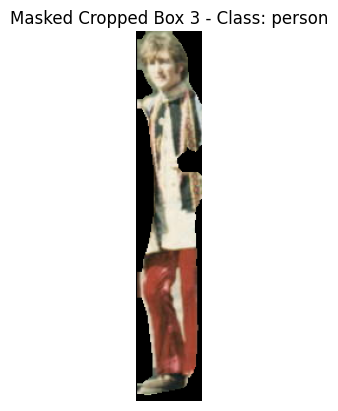

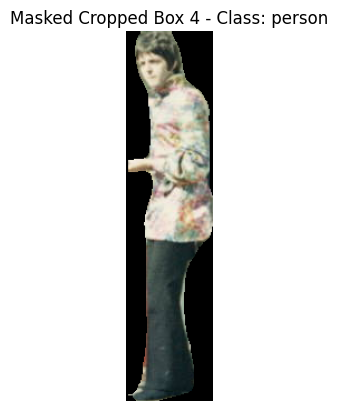

Skipping box 5 as it is not a person.
Skipping box 6 as it is not a person.
Skipping box 7 as it is not a person.


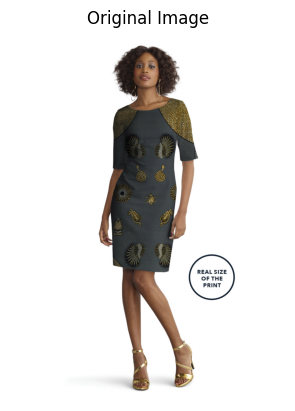


0: 640x480 1 person, 908.1ms
Speed: 3.1ms preprocess, 908.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


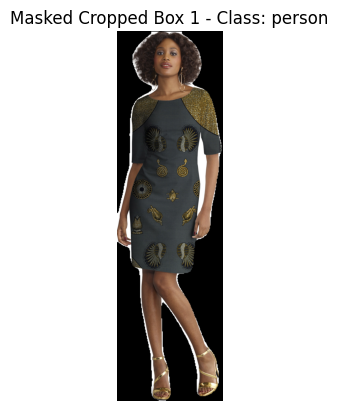

In [3]:
model = YOLO("yolov8l-seg.pt")
images = [cv2.imread("../data/X.jpg"), cv2.imread("../data/Y.jpg"), cv2.imread("../data/YY.jpg"), cv2.imread("../data/Z.jp2")]
cropped_images = []
for image in images:
    cropped_images.extend(segment_and_crop_image(image, model, show_images=True))

# Cloth Segmentation

In [4]:
# Cloth segmentation model initialization
seg_processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
seg_model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

segmented_images = []
cropped_seg_images = []

for cropped_image in cropped_images:
    # Convert the cropped image to a PIL image
    cropped_image_pil = Image.fromarray(cropped_image, mode='RGB')
    
    # Get cloth segmentation mask
    segmented_image = get_segmentation_mask(cropped_image_pil, seg_processor, seg_model)

    # Append the segmented image to the list
    segmented_images.append(segmented_image)

    # Convert the tensor to a numpy array
    segmented_image = segmented_image.cpu().numpy()
    segmented_image = np.array(segmented_image, dtype=np.uint8)

    # Create a 3-channel mask
    segmented_image_3ch = np.stack([segmented_image] * 3, axis=-1)

    # Apply the mask to the input image
    # filtered_image_np = np.where(segmented_image_3ch == 255, np.array(image), 0)
    filtered_image_np = np.where(segmented_image_3ch == 255, np.array(cropped_image_pil), 0)

    # Find the bounding box of the segmentation mask
    coords = np.column_stack(np.where(segmented_image == 255))
    # Check if the segmentation mask is all black
    if coords.size > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        # Crop the original image using the bounding box coordinates
        cropped_image = filtered_image_np[y_min:y_max+1, x_min:x_max+1]

        # Convert the cropped image to a numpy array if needed
        cropped_image_np = np.array(cropped_image)

        # Display the Image
        cropped_image_pil = Image.fromarray(cropped_image_np, mode='RGB')
    else:
        print("The segmentation mask is all black. Skipping cropping operation.")
        # Convert the filtered image back to PIL format
        cropped_image_pil = Image.fromarray(filtered_image_np, mode='RGB')

        cropped_image_pil = cropped_image_pil.convert("RGB")
        # continue
    
    # Append the cropped segmented image to the list
    cropped_seg_images.append(cropped_image_pil)

/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


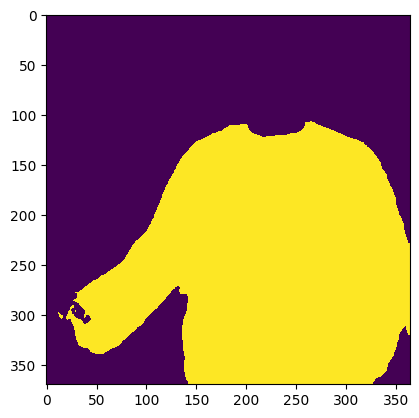

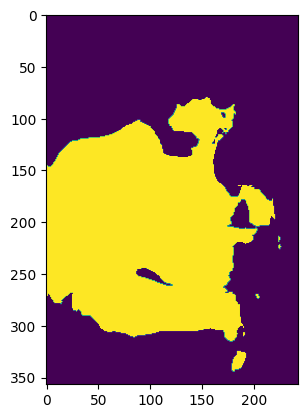

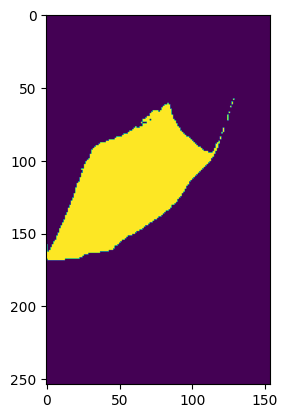

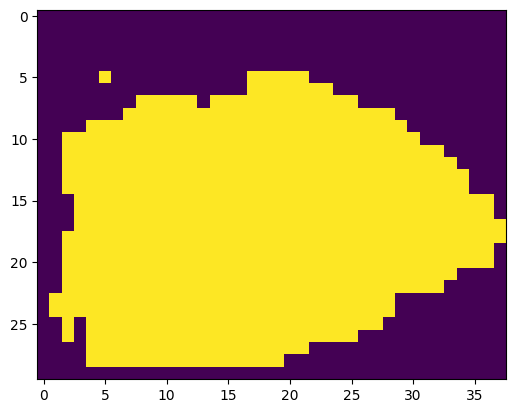

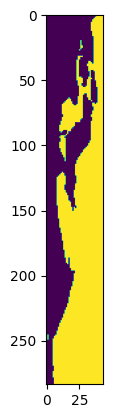

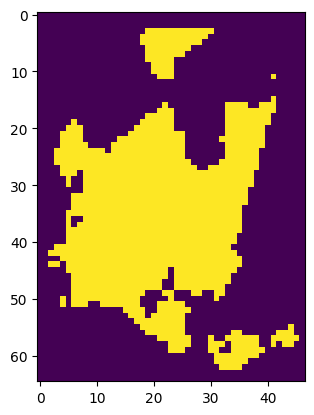

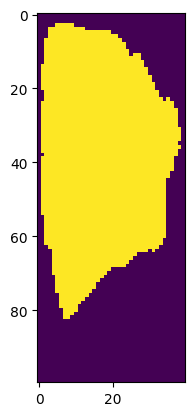

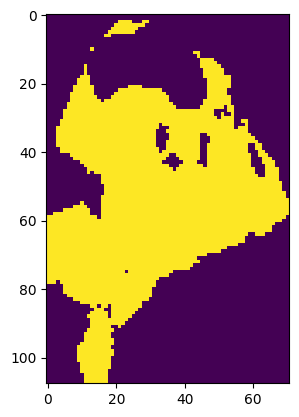

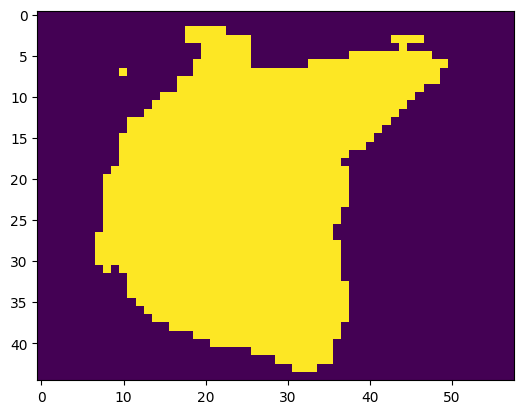

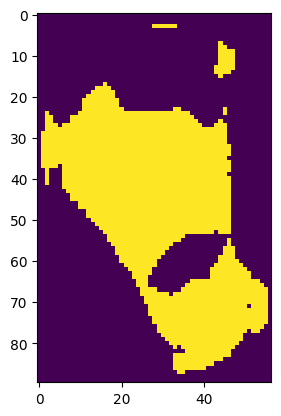

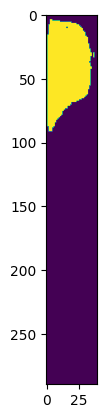

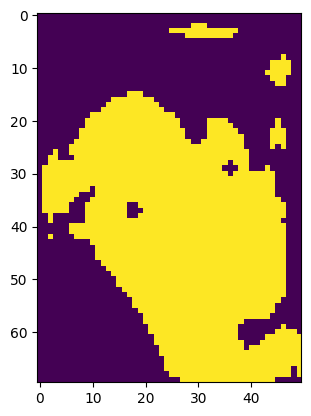

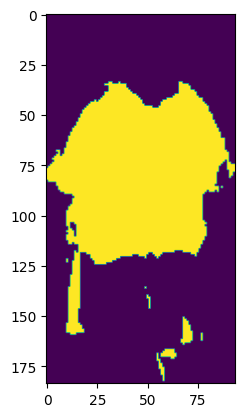

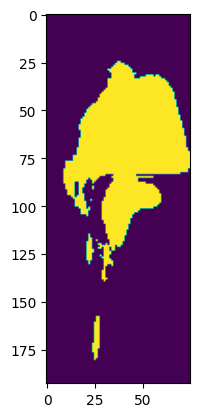

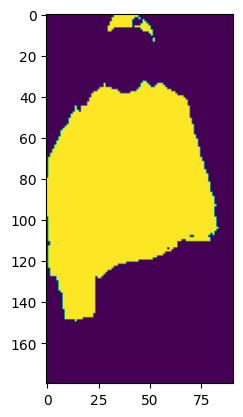

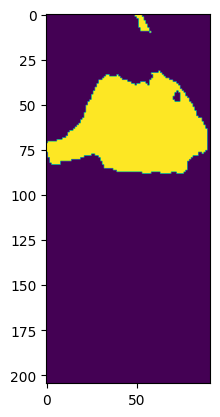

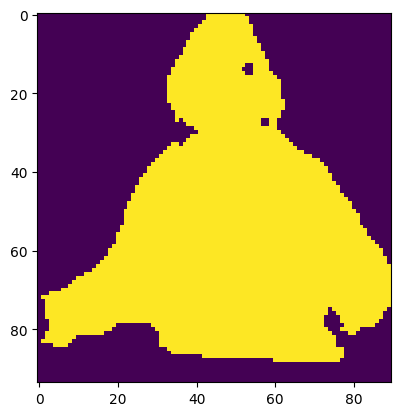

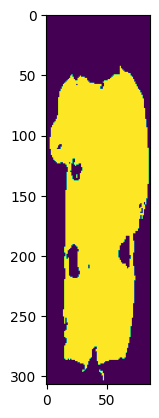

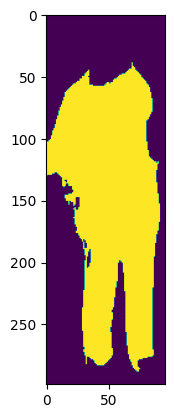

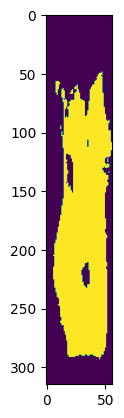

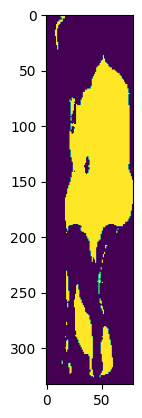

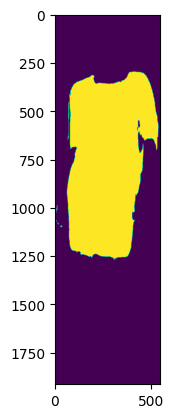

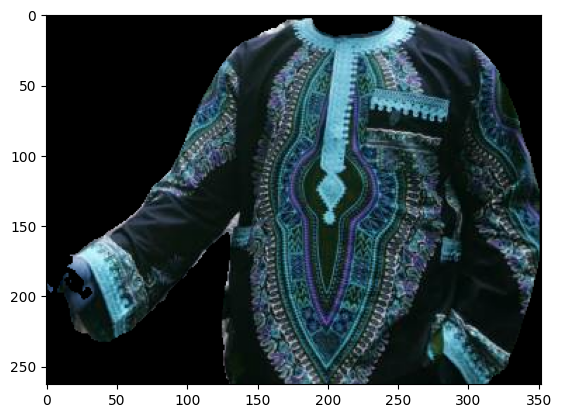

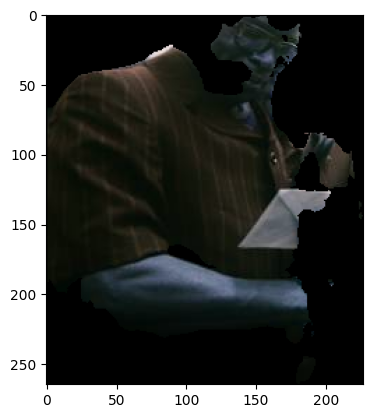

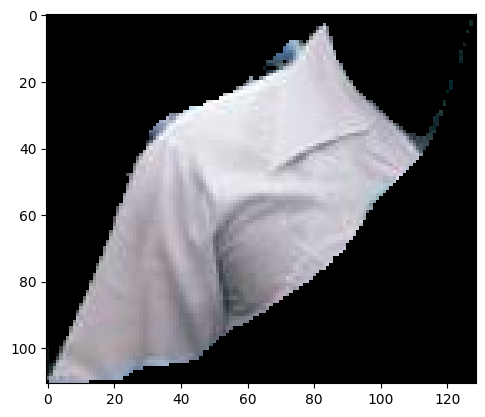

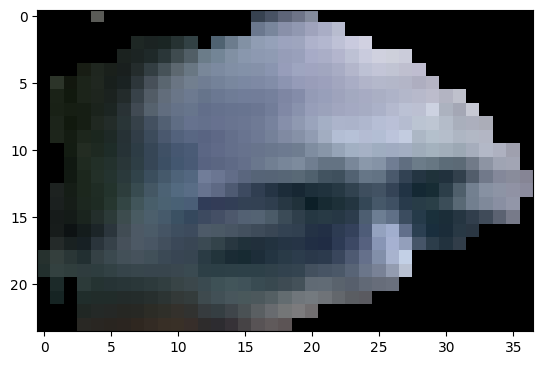

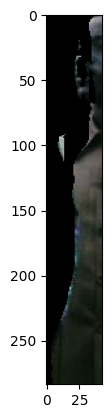

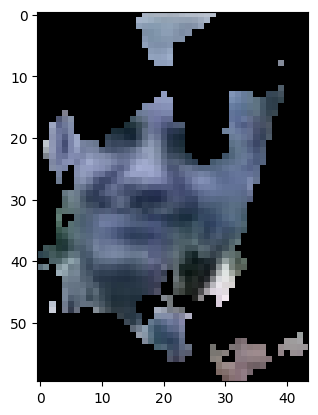

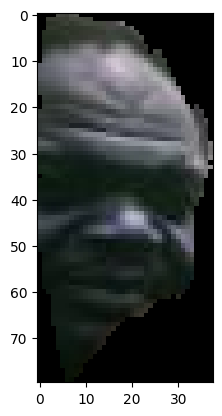

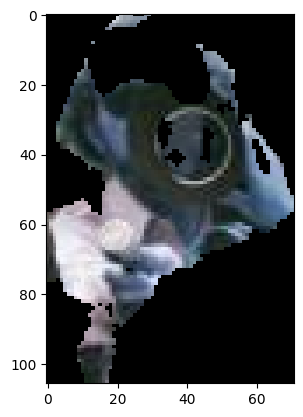

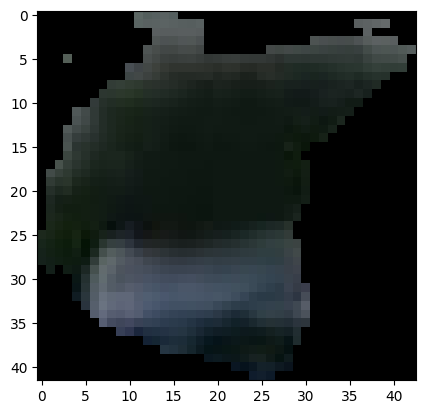

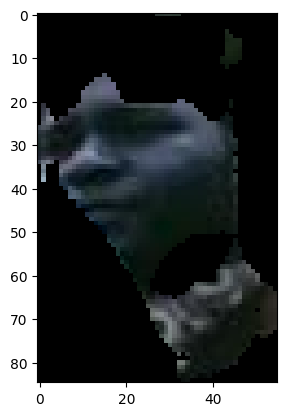

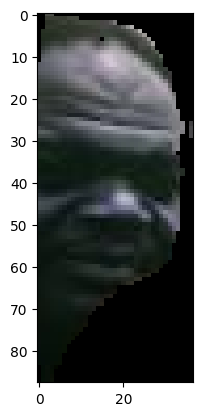

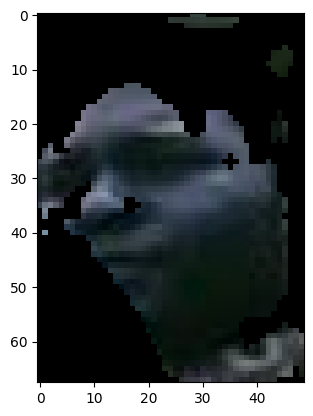

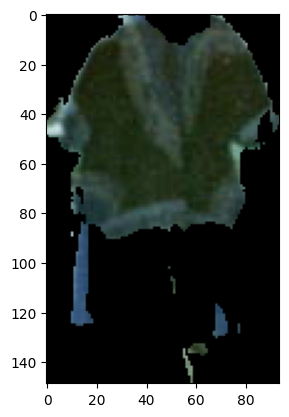

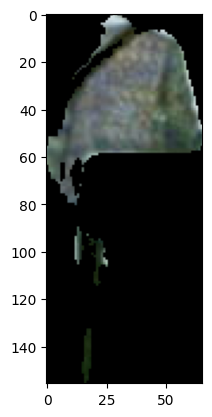

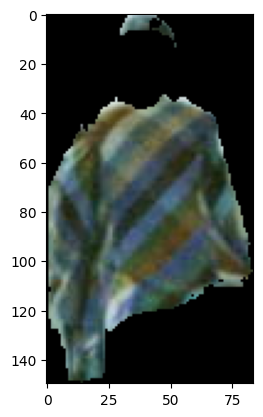

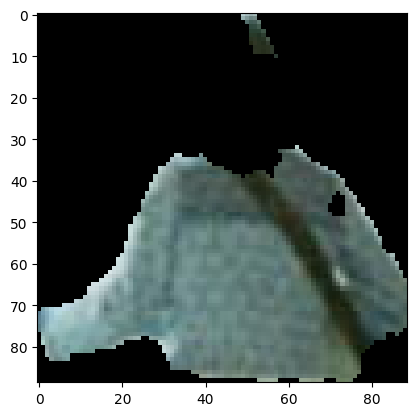

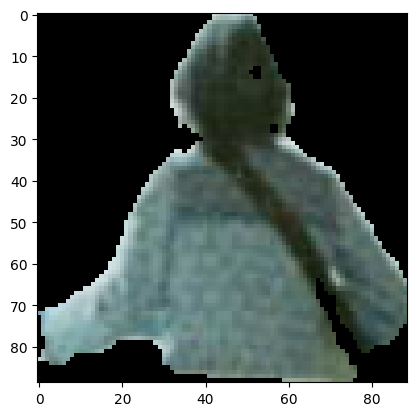

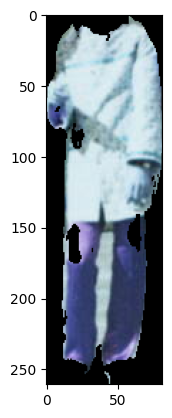

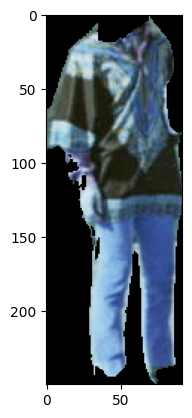

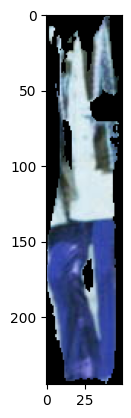

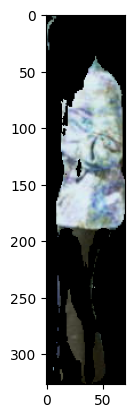

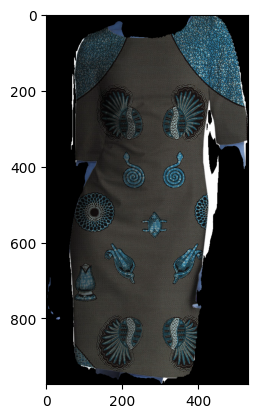

In [5]:
for segmented_image in segmented_images:
    plt.imshow(segmented_image)
    plt.show()

for cropped_seg_image in cropped_seg_images:
    plt.imshow(cropped_seg_image)
    plt.show()